In [1]:
import dolfin as fn
import numpy as np
import scipy.io as sio
import scipy.stats as sps
import re

from matplotlib import pyplot as plt
from seaborn import color_palette
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

# Representing the Permeability Field

Consider the following incompressible flow model which describes the pressure field $p$ in terms of a permeability field $K(\lambda;x)$ with simple boundary conditions:

\begin{align}
\begin{cases}
-\nabla\cdot(K(\lambda;x)\nabla p)=0, & x\in\Omega=(0,1)^2 \\
p=1, & x_1=0 \\
p=0, & x_1=1 \\
K\nabla p \cdot {\bf n} =0, & x_2=0\ \text{and}\ x_2=1
\end{cases}
\end{align}

In this example we represent the permeability field $K(\lambda;x)$ of this PDE using the KL Expansion of a Gaussian process. 

Our goal is to show that we can represent and infer the KL expansion using only a few main eigencomponents while treating the remaining eigencomponents of the KL expansion as additional "stochastic uncertainty". We will use Data-consistent Inversion (DCI) to infer the distribution of the updated eigencomponents using observed data.

See the dissertation for details.

## Load the Eigenfunctions and Eigenvalues

Computing the high resolution KL expansion is expensive for the average computer (takes a few hours to run).

Thus, we do this computation in a separate notebook. You can see and run these computations in [Compute_KL_Expansions](Compute_KL_Expansions.ipynb).

**High-Resolution KL**
* 50x50 triangular element grid

In [2]:
# load KL expansion for a fine-grained mesh
fineKL_dict = sio.loadmat('KL_expansion')
numKL = fineKL_dict['eigen_val'].shape[1]
fineKL_dict['V_space'] = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),50,50),'Lagrange',1)

print(numKL)

Calling FFC just-in-time (JIT) compiler, this may take some time.
100


**Low-Resolution KL**
* 10x10 triangular element grid

In [3]:
# load KL expansion for a fine-grained mesh
coarseKL_dict = sio.loadmat('KL_expansion_coarse')
numKL = fineKL_dict['eigen_val'].shape[1]
coarseKL_dict['V_space'] = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),10,10),'Lagrange',1)

print(numKL)

100


## Check the Eigenvalues and Eigenfunctions

In [4]:
# check shapes of eigenvalues
print(fineKL_dict['eigen_val'].shape)
print(coarseKL_dict['eigen_val'].shape)

# check shapes of eigen_matrices
print(fineKL_dict['eigen_func'].shape)
print(coarseKL_dict['eigen_func'].shape)

(1, 100)
(1, 100)
(100, 2601)
(100, 121)


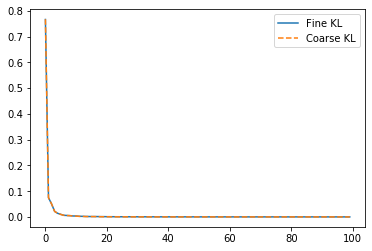

In [5]:
# plot eigenvalues
plt.figure()
plt.plot(fineKL_dict['eigen_val'].reshape(-1,),label='Fine KL')
plt.plot(coarseKL_dict['eigen_val'].reshape(-1,),label='Coarse KL',ls='--')
plt.legend()

Text(0.5, 1.0, 'Differences in Eigenvalues')

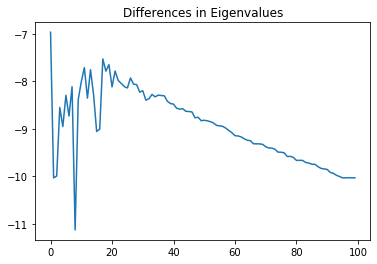

In [6]:
plt.plot(np.log(np.abs(fineKL_dict['eigen_val']-coarseKL_dict['eigen_val'])).reshape(-1))
plt.title('Differences in Eigenvalues')

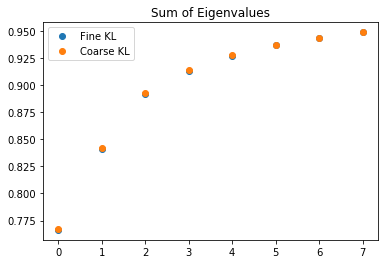

In [7]:
fineCUM = np.cumsum(fineKL_dict['eigen_val'].reshape(-1,)[:8])
coarseCUM = np.cumsum(coarseKL_dict['eigen_val'].reshape(-1,)[:8])

# plot sum eigenvalues
plt.figure()
plt.title('Sum of Eigenvalues')
plt.plot(fineCUM,label='Fine KL',marker='o',ls='None')
plt.plot(coarseCUM,label='Coarse KL',marker='o',ls='None')
plt.legend()

## Make plots of the First Four Eigenfunctions

In [8]:
def produce_perm_field(KL_space,random_weights,eigen_val,eigen_func,approx=None):
    '''
    produces a log permeability field example
    KL_space: the FE function space to apply function to; should match with the space eigen_functions were computed on
    random_weights: sampled lambda weights for each term of the KL-expansion; should be size eigen_val
    eigen_val: eigen_values of KL expansion; should be shape (1,numberKL terms)
    eigen_func: matrix of eigenfunctions. should be shape (numberKL, number_meshpoints)
    '''
    
    if type(approx)==type(None):
        xi_val = np.zeros(eigen_func.shape[1])
    else:
        xi_val = approx
    
    perm_K = fn.Function(KL_space)
    Y = np.dot(random_weights*np.sqrt(eigen_val),eigen_func)
    
    perm_K.vector()[:] = np.exp(Y.reshape(-1,)+1+xi_val.reshape(-1,))
    
    return perm_K

In [9]:
coarseKL_dict['eigen_func'].shape

(100, 121)

In [10]:
def get_eigen_func(this_space,eigen_func,eigen_space):
    '''
    projects eigenfunctions on this space from its native space
    this_space: fenics function space
    eigen_func: an array of vector values representing the eigenfunction
    eigen_space: the fenics function space corresponding to the eigen_func
    
    returns a fenics function object in the space "this_space"
    ''' 
    # sets up eigenfunction
    this_eigen_func = fn.Function(eigen_space)
    this_eigen_func.vector()[:] = 1*eigen_func.reshape(-1,)
    
    project_func = fn.project(this_eigen_func,this_space)
    
    return project_func

**For Coarse-Grid Eigenfunctions:**

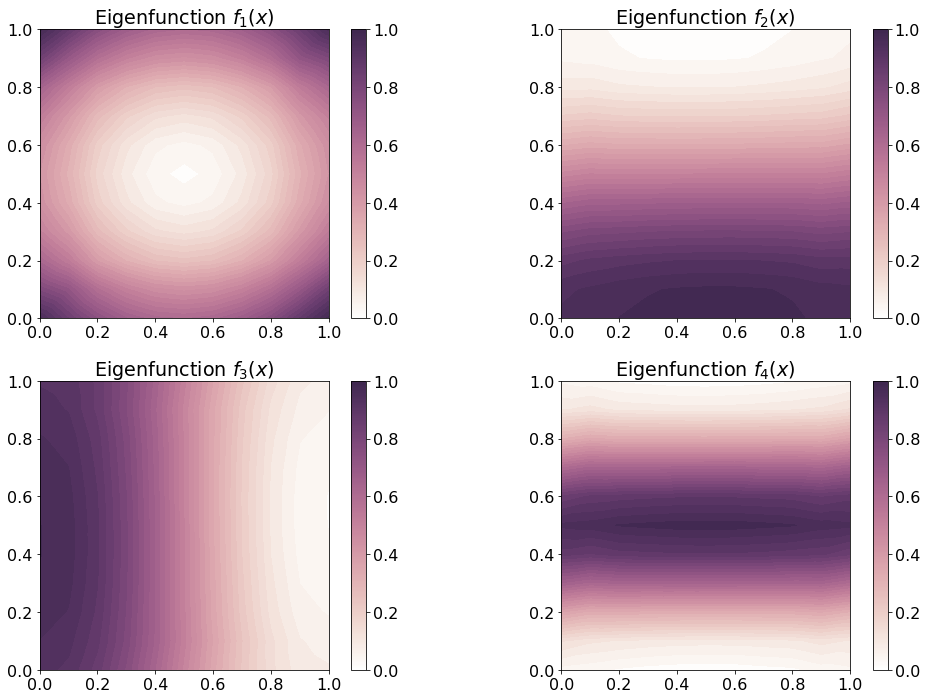

In [103]:
plt.rcParams.update({'font.size': 16})

# sets color for the plots
these_colors = sns.cubehelix_palette(light=1,dark=0.2, as_cmap=True)

# sets up the plot function space
pltspace = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20),'Lagrange',1)


fig_eigen, axes = plt.subplots(2,2)
fig_eigen.set_figheight(10)
fig_eigen.set_figwidth(16)

# reshape axes into a single vector
axes = axes.reshape(-1,)

for i,ax in enumerate(axes):
    fig_eigen.sca(ax)
    this_eigen_func = get_eigen_func(pltspace,coarseKL_dict['eigen_func'][i],coarseKL_dict['V_space'])
    field_plot = fn.plot(this_eigen_func)
    field_plot.set_cmap(these_colors)
    m = plt.cm.ScalarMappable(cmap=these_colors)
    #m.set_array(this_eigen_func.vector())
    #m.set_clim(0,4)
    #field_plot.set_clim(0,7)
    plt.colorbar(m,fraction=0.046, pad=0.04)
    plt.title('Eigenfunction $f_{}(x)$'.format(i+1))
plt.tight_layout()

In [104]:
# # save the above figure
# fig_eigen.savefig('KL_eigen_func.png')

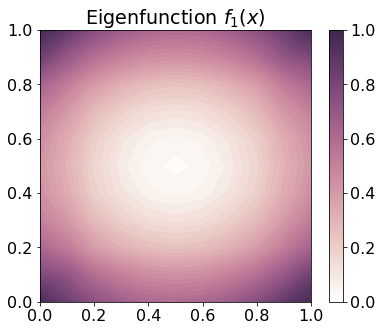

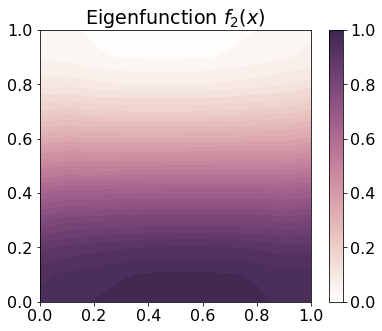

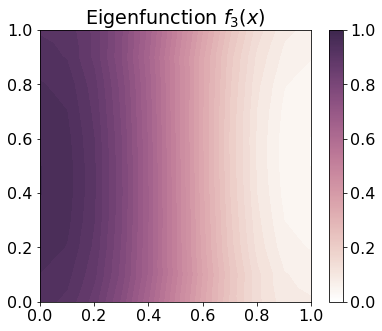

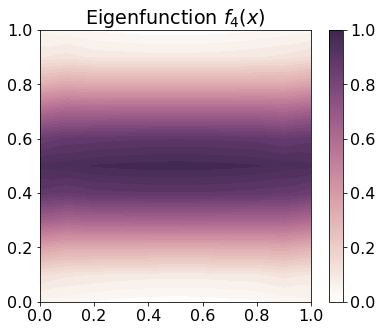

In [17]:
# matplotlib
plt.rcParams.update({'font.size': 16})

# produce separate eigenfunction images
# sets color for the plots
these_colors = sns.cubehelix_palette(light=1,dark=0.2, as_cmap=True)

# sets up the plot function space
pltspace = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20),'Lagrange',1)

eigen_figure_list = []
for i in np.arange(4):
    fig_eigenS, ax = plt.subplots(1)
    fig_eigenS.set_figheight(5)
    fig_eigenS.set_figwidth(8)
    this_eigen_func = get_eigen_func(pltspace,coarseKL_dict['eigen_func'][i],coarseKL_dict['V_space'])
    field_plot = fn.plot(this_eigen_func)
    field_plot.set_cmap(these_colors)
    m = plt.cm.ScalarMappable(cmap=these_colors)
    #m.set_array(this_eigen_func.vector())
    #m.set_clim(0,4)
    #field_plot.set_clim(0,7)
    plt.colorbar(m,fraction=0.046, pad=0.04)
    plt.title('Eigenfunction $f_{}(x)$'.format(i+1))
    
    eigen_figure_list.append(fig_eigenS)

In [20]:
# # save figures
# for j,fig in enumerate(eigen_figure_list):
#     fig.savefig('KL_eigen_func{}.png'.format(j+1),bbox_inches='tight')

In [24]:
coarseKL_dict['eigen_func'][3]

array([-1.37892133, -1.21032799, -1.40660668, -0.56922774, -1.16837517,
       -1.45994634,  0.30131386, -0.47408219, -1.2198545 , -1.47323328,
        1.04917487,  0.41245018, -0.51441769, -1.23118557, -1.49093022,
        1.37795282,  1.1324353 ,  0.4007667 , -0.51493069, -1.24359224,
       -1.49443185,  1.15605442,  1.39992975,  1.15404751,  0.41123225,
       -0.52087691, -1.24598691, -1.48992156,  0.47264723,  1.10811137,
        1.44633758,  1.17141884,  0.41524842, -0.52165765, -1.24101876,
       -1.47566757, -0.39846232,  0.3740017 ,  1.16064612,  1.4638117 ,
        1.18380318,  0.41686753, -0.5195141 , -1.22791859, -1.45262886,
       -1.1091464 , -0.50978979,  0.41201018,  1.17115594,  1.47975634,
        1.18723359,  0.41622809, -0.51420175, -1.2080205 , -1.41695639,
       -1.38970524, -1.18136724, -0.50298472,  0.41138649,  1.18429216,
        1.48371941,  1.18429216,  0.41138649, -0.50298472, -1.18136724,
       -1.38970524, -1.41695639, -1.2080205 , -0.51420175,  0.41

**For Fine-Grid Eigenfunctions:**

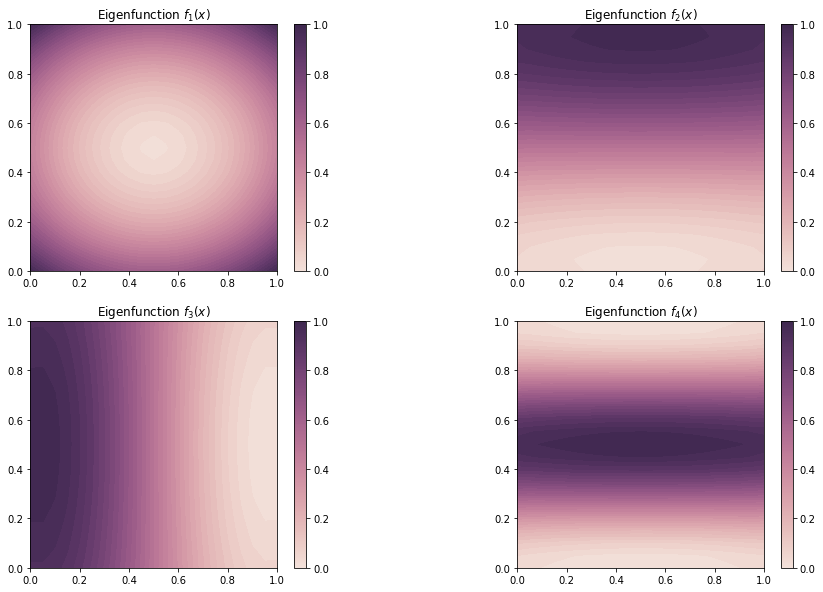

In [13]:
# sets color for the plots
these_colors = sns.cubehelix_palette(light=0.9,dark=0.2, as_cmap=True)

# sets up the plot function space
pltspace = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20),'Lagrange',1)


fig_eigen2, axes = plt.subplots(2,2)
fig_eigen2.set_figheight(10)
fig_eigen2.set_figwidth(16)

# reshape axes into a single vector
axes = axes.reshape(-1,)

for i,ax in enumerate(axes):
    fig_eigen2.sca(ax)
    this_eigen_func = get_eigen_func(pltspace,fineKL_dict['eigen_func'][i],fineKL_dict['V_space'])
    field_plot = fn.plot(this_eigen_func)
    field_plot.set_cmap(these_colors)
    m = plt.cm.ScalarMappable(cmap=these_colors)
    #m.set_array(this_eigen_func.vector())
    #m.set_clim(0,4)
    #field_plot.set_clim(0,7)
    plt.colorbar(m,fraction=0.046, pad=0.04)
    plt.title('Eigenfunction $f_{}(x)$'.format(i+1))

**Numerical Computation of Differences between the Eigenfunctions:**

In [14]:
# sets up the plot function space
pltspace = fn.FunctionSpace(fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20),'Lagrange',2)

L2_diff = np.zeros(100)
for i,val in enumerate(L2_diff):
    this_coarse_E = get_eigen_func(pltspace,np.sqrt(coarseKL_dict['eigen_val'][0,i])*coarseKL_dict['eigen_func'][i],coarseKL_dict['V_space'])
    this_fine_E = get_eigen_func(pltspace,np.sqrt(fineKL_dict['eigen_val'][0,i])*fineKL_dict['eigen_func'][i],fineKL_dict['V_space'])
    this_norm = fn.sqrt(fn.assemble((this_coarse_E-this_fine_E)**2*fn.dx))
    L2_diff[i] = this_norm

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [15]:
print('The max error in the L2 norm between Coarse and Fine is: ',max(L2_diff))
#print(L2_diff)

The max error in the L2 norm between Coarse and Fine is:  0.5459154727176574


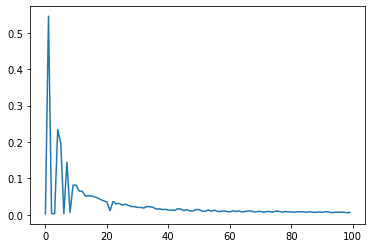

In [16]:
plt.plot(L2_diff)

## Compute the Permeability Field

Here we sample the permeability from the KL-expansion. The permeability field $K(\vec{\lambda} ; x)$ is:

\begin{align*}
K(\vec{\lambda}; x)&=\exp\left(Y+1\right)
\end{align*}

where $\vec{\lambda}$ is a vector of random variables and $Y$ is the KL-expansion:

\begin{align}
Y &= \sum_{i=0}^\infty \lambda_i \cdot \sqrt{\eta_i} \cdot f_i(x)
\end{align}


In [21]:
# number of samples of the perm-field
n_samples = 3500

In [22]:
# define initial
lam_init = sps.norm(0,1)

# compute the QoI for each sample
lam_samples = lam_init.rvs(size=[n_samples,100])


In [23]:
def produce_perm_field(KL_space,random_weights,eigen_val,eigen_func,approx=None):
    '''
    produces a log permeability field example
    KL_space: the FE function space to apply function to; should match with the space eigen_functions were computed on
    random_weights: sampled lambda weights for each term of the KL-expansion; should be size eigen_val
    eigen_val: eigen_values of KL expansion; should be shape (1,numberKL terms)
    eigen_func: matrix of eigenfunctions. should be shape (numberKL, number_meshpoints)
    '''
    
    if type(approx)==type(None):
        xi_val = np.zeros(eigen_func.shape[1])
    else:
        xi_val = approx
    
    perm_K = fn.Function(KL_space)
    Y = np.dot(random_weights*np.sqrt(eigen_val),eigen_func)
    
    perm_K.vector()[:] = np.exp(Y.reshape(-1,)+1+xi_val.reshape(-1,))
    
    return perm_K

In [24]:
# define examples, computational mesh and output dictionary
nKL_kept = 4
examples = [('cKL'+str(nKL_kept),coarseKL_dict,nKL_kept), 
            ('cKL'+str(100),coarseKL_dict,100), 
            ('cKL'+str(nKL_kept)+'_E',coarseKL_dict,nKL_kept)]

# mesh and fe space
comp_mesh = fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20)
V_comp = fn.FunctionSpace(comp_mesh, "Lagrange", 1)

# inputs
my_input = {}

# output
my_output = {}

In [25]:
# compute the permeability fields for each example
for example in examples:
    
    # parse the example
    example_name = example[0]
    example_dict = example[1]
    nKL = example[2]
    trunc_error_term = True if example_name=='cKL'+str(nKL)+'_E' else False
    
    # a list of all the permfields for this example
    perm_fields = []
    
    
    # if this is the perm-field with truncation error problem
    if trunc_error_term:
        # compute the standard deviation
        std_dev = np.sqrt(1-np.dot(example_dict['eigen_val'][:,:nKL],example_dict['eigen_func'][:nKL]**2))
        noise = sps.norm.rvs(0,1,size=[len(lam_samples),example_dict['eigen_func'].shape[1]])
        xi_sample = std_dev*noise
    else:
        xi_sample = [None]*len(lam_samples)
    
    # compute the permeability field for each sample
    for i,lam in enumerate(lam_samples):
        # updates permeability field
        lam_i = lam[:nKL].reshape(example_dict['eigen_val'][:,:nKL].shape)
        this_field = produce_perm_field(example_dict['V_space'],
                                        lam_i,
                                        example_dict['eigen_val'][:,:nKL],
                                        example_dict['eigen_func'][:nKL],
                                        approx=xi_sample[i])
        
        
        # define the perm field on the comp mesh
        perm_K = fn.project(this_field,V_comp)
        
        # append the perm field to the list
        perm_fields.append(perm_K)
    
    # save list of inputs
    my_input[example_name] = {}
    my_input[example_name]['nKL'] = nKL
    my_input[example_name]['lam_init'] = lam_samples
    my_input[example_name]['xi_init'] = xi_sample
    my_input[example_name]['perm_K'] = perm_fields
    

[3268, 2624, 257]


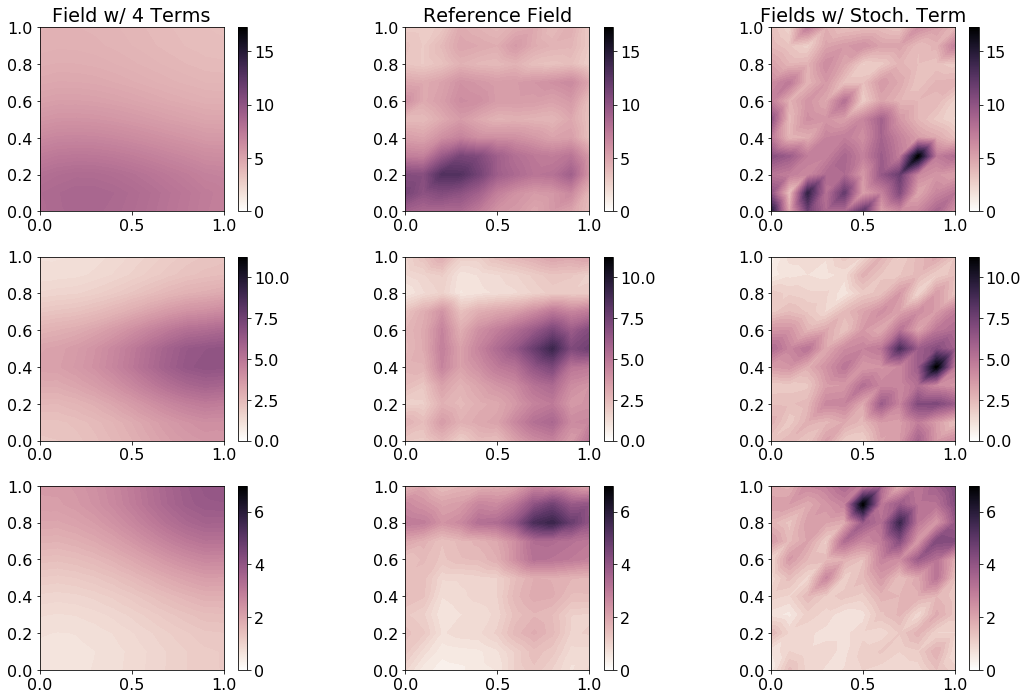

In [105]:
# choose example fields to plot
n_fields = 3
# example_fields = np.random.choice(np.arange(lam_samples.shape[0]),n_fields, replace=False)
example_fields = [3268, 2624, 257]
print(example_fields)

titles = ['Field w/ 4 Terms', 'Reference Field', 'Fields w/ Stoch. Term']
# compare permeability fields
fig_perm, axes = plt.subplots(n_fields,len(my_input.keys()))
fig_perm.set_figheight(10)
fig_perm.set_figwidth(16)

# colorscheme for the plots
these_colors = sns.cubehelix_palette(light=1,dark=0, as_cmap=True)

# plot on each axes
for i,num in enumerate(example_fields):
    # get color max for the row
    color_maxes = []
    for j, example in enumerate(my_input.keys()):
        color_maxes.append(max(my_input[example]['perm_K'][num].vector()))
    color_max = max(color_maxes)
    
    # plot each field
    for j, example in enumerate(my_input.keys()):
        this_output = my_input[example]['perm_K'][num]
        fig_perm.sca(axes[i,j])
        
        field_plot = fn.plot(this_output,vmin=0,vmax=color_max)
        field_plot.set_cmap(these_colors)
        m = plt.cm.ScalarMappable(cmap=these_colors)
        m.set_array(this_output.vector())
        m.set_clim(0,color_max)
        #field_plot.set_clim(0,7)
        plt.colorbar(m,fraction=0.046, pad=0.04)
        
        if i==0:
            axes[i,j].set_title(titles[j])

plt.tight_layout()

In [106]:
# fig_perm.savefig('KL_perm_field.png')

[3268, 2624, 257]


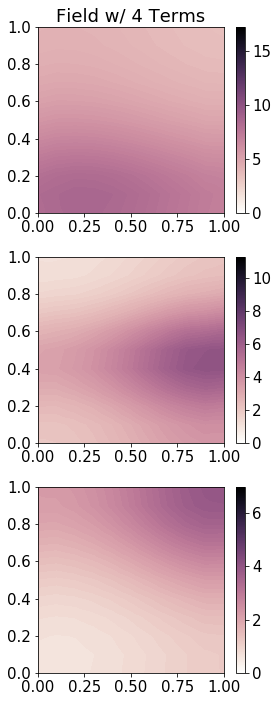

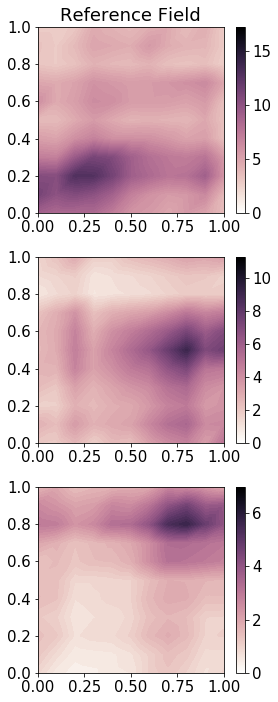

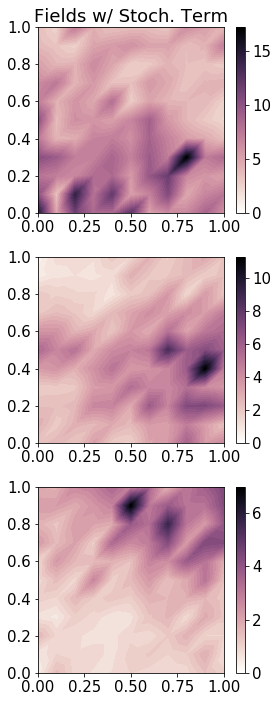

In [39]:
# font size
plt.rcParams.update({'font.size': 15})

# Column Figures
# choose example fields to plot
n_fields = 3
# example_fields = np.random.choice(np.arange(lam_samples.shape[0]),n_fields, replace=False)
example_fields = [3268, 2624, 257]
print(example_fields)


titles = ['Field w/ 4 Terms', 'Reference Field', 'Fields w/ Stoch. Term']
perm_field_figs = []

for j,example in enumerate(my_input.keys()):
    # compare permeability fields
    fig_perm, axes = plt.subplots(n_fields)
    fig_perm.set_figheight(10)
    fig_perm.set_figwidth(5)

    # colorscheme for the plots
    these_colors = sns.cubehelix_palette(light=1,dark=0, as_cmap=True)

    # plot on each axes
    for i,num in enumerate(example_fields):
        # get color max for the row
        color_maxes = []
        for k, ex in enumerate(my_input.keys()):
            color_maxes.append(max(my_input[ex]['perm_K'][num].vector()))
        color_max = max(color_maxes)

        # plot each field
#         for j, example in enumerate(my_input.keys()):
        this_output = my_input[example]['perm_K'][num]
        fig_perm.sca(axes[i])

        field_plot = fn.plot(this_output,vmin=0,vmax=color_max)
        field_plot.set_cmap(these_colors)
        m = plt.cm.ScalarMappable(cmap=these_colors)
        m.set_array(this_output.vector())
        m.set_clim(0,color_max)
        #field_plot.set_clim(0,7)
        plt.colorbar(m,fraction=0.046, pad=0.04)

        if i==0:
            axes[i].set_title(titles[j])

        plt.tight_layout()
    perm_field_figs.append(fig_perm)

In [42]:
for k,fig in enumerate(perm_field_figs):
    fig.savefig('KL_perm_field_col{}.png'.format(k+1),bbox_inches='tight')

# Compute the Quantity of Interest

Set up the conditions for solving the PDE.

In [43]:
# Define the mix of Neumann and Dirichlet BCs

class LeftBoundary(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (x[0] < fn.DOLFIN_EPS)
class RightBoundary(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (x[0] > 1.0 - fn.DOLFIN_EPS)
class TopBoundary(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (x[1] > 1.0 - fn.DOLFIN_EPS)
class BottomBoundary(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (x[1] < fn.DOLFIN_EPS)
    
# define the space and computational mesh
for key in my_input.keys():
    my_input[key]['mesh'] = fn.RectangleMesh(fn.Point(0,0),fn.Point(1,1),20,20)
    mesh = my_input[key]['mesh']
    my_input[key]['V'] = fn.FunctionSpace(mesh, "Lagrange", 1)

for key in my_input.keys():
    # load space
    mesh = my_input[key]['mesh']
    V = my_input[key]['V']
    mf = fn.MeshFunction('size_t', mesh, 1)
    mf.set_all(0) # initialize the function to be zero

    # Setup the boundary classes that use Neumann boundary conditions
    NTB = TopBoundary() # instatiate
    NTB.mark(mf, 1) # set all values of the mf to be 1 on this boundary

    NBB = BottomBoundary()
    NBB.mark(mf, 2) # set all values of the mf to be 2 on this boundary
    
    # Define Dirichlet boundary conditions
    Gamma_0 = fn.DirichletBC(V, fn.Constant(1), LeftBoundary())
    Gamma_1 = fn.DirichletBC(V, fn.Constant(0), RightBoundary())
    my_input[key]['bcs'] = [Gamma_0, Gamma_1]

    # Define data necessary to approximate exact solution
    my_input[key]['f'] = fn.Constant(0)
    my_input[key]['g'] = fn.Constant(0.0)


Define a function which solves the PDE for a given random field.

In [44]:
def solvePoissonRandomField(rand_field,V,f,g,bcs):
    """
    Solves the poisson equation with a random field :
    (\grad \dot (rand_field \grad(u)) = -f)
    """
    u = fn.TrialFunction(V)
    v = fn.TestFunction(V)

    a = fn.inner(rand_field*fn.grad(u),fn.grad(v))*fn.dx
    L = f*v*fn.dx + rand_field*g*v*fn.ds(1) + rand_field*g*v*fn.ds(2) # note the 1 and 2 correspond to the mf
    
    u = fn.Function(V)
    fn.solve(a == L, u, bcs)
    
    return u

Defines the QoI computed after the PDE is solved.

In [45]:
# define the QoI map for the solution
def QoI_map(u):
    point_value = u(0.25,0.5)
    return point_value

Function which computes the push forward for conditions described in input dictionary and the QoI map.

In [46]:
def compute_pf(input_dictionary):
    '''
    Computes quantities and outputs desired quantities as dictionary
    input_dictionary: a dictionary of inputs that includes a list of permeability fields and PDE conditions to solve
                        the PDE using finite elements code
    
    returns: out_dict, a dictionary of quantities to examine
    '''
    
    # define outputs
    out_dict = {}
    u_list = []
    
    # define input values
    input_samples = input_dictionary['lam_init']
    n = input_samples.shape[0]
    pf_samples = np.zeros(n)
    
    # estalish local variables
    V = input_dictionary['V']
    mesh = input_dictionary['mesh']
    bcs = input_dictionary['bcs']
    f,g = input_dictionary['f'], input_dictionary['g']
    perm_list = input_dictionary['perm_K']
    
    for i in np.arange(n):
        # this perm
        perm_K = fn.project(perm_list[i],V)
        
        # solve the PDE for u
        u = solvePoissonRandomField(perm_K,V,f,g,bcs)
        
        # append the output functions to a list
        u_list.append(u)
        
        # progress bar
        if (i % int(n_samples/10))==0:
            print(i)

        # compute QoI from u
        pf_samples[i] = QoI_map(u)
        
    out_dict['perm_list'] = perm_list
    out_dict['lam_init'] = input_samples
    out_dict['sample_u'] = u_list
    out_dict['pf_samples'] = pf_samples
    
    return out_dict
    

In [47]:
# create output dictionary
my_output = {}

# compute the examples
for example in my_input.keys():
    print('Computing solutions to example ', example, ':')
    my_output[example] = compute_pf(my_input[example])

Computing solutions to example  cKL4 :
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
0
350
700
1050
1400
1750
2100
2450
2800
3150
Computing solutions to example  cKL100 :
0
350
700
1050
1400
1750
2100
2450
2800
3150
Computing solutions to example  cKL4_E :
0
350
700
1050
1400
1750
2100
2450
2800
3150


## Check Solution

Plots a few solutions $u$ to the PDE:

[1230 3243 1291]


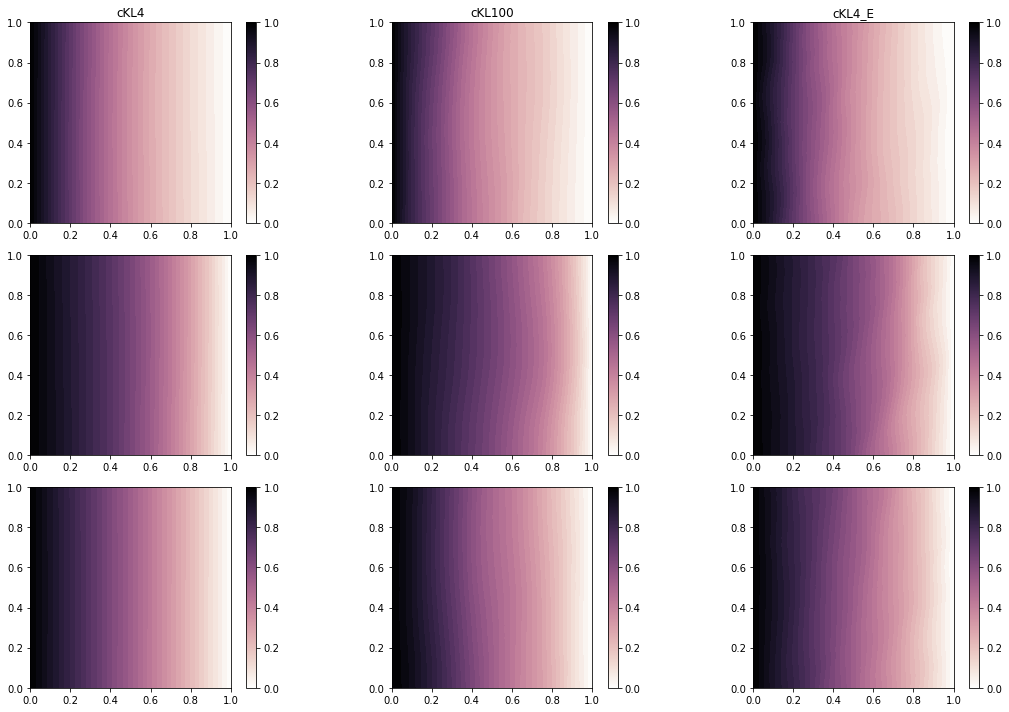

In [92]:
# choose example solutions to plot
n_sols = 3
example_sols = np.random.choice(np.arange(len(my_output['cKL4']['sample_u'])),n_sols, replace=False)
print(example_sols)

# compare permeability fields
fig_perm, axes = plt.subplots(n_sols,len(my_output.keys()))
fig_perm.set_figheight(10)
fig_perm.set_figwidth(16)

# colorscheme for the plots
these_colors = sns.cubehelix_palette(light=1,dark=0, as_cmap=True)

# plot on each axes
for i,num in enumerate(example_sols):
    # get color max for the row
    color_maxes = []
    for j, example in enumerate(my_output.keys()):
        color_maxes.append(max(my_output[example]['sample_u'][num].vector()))
    color_max = max(color_maxes)
    
    # plot each field
    for j, example in enumerate(my_output.keys()):
        this_output = my_output[example]['sample_u'][num]
        fig_perm.sca(axes[i,j])
        
        field_plot = fn.plot(this_output,vmin=0,vmax=color_max)
        field_plot.set_cmap(these_colors)
        m = plt.cm.ScalarMappable(cmap=these_colors)
        m.set_array(this_output.vector())
        m.set_clim(0,color_max)
        #field_plot.set_clim(0,7)
        plt.colorbar(m,fraction=0.046, pad=0.04)
        
        if i==0:
            axes[i,j].set_title(example)

plt.tight_layout()

# Data-Consistent Inversion

Defines the observed distribution.

In [48]:
# define observed at the QoI point
data_pdf = sps.norm(0.68,np.sqrt(1e-4))

Defines the push-forward distribution for each example.

In [49]:
# uses gaussian_kde to compute the push-forward distribution
for example in my_input.keys():
    my_output[example]['pf_kde'] = sps.gaussian_kde(my_output[example]['pf_samples'])

Computes the weights from the mismatch between observed and push-forward for each example.

In [50]:
for example in my_input.keys():
    my_output[example]['weights'] = data_pdf.pdf(my_output[example]['pf_samples'])/my_output[example]['pf_kde'](my_output[example]['pf_samples'])
    

Plots the Updated Distributions of the Components of the KL-Expansion

Text(0.5, 0.98, 'Updates of Parameters of Interest')

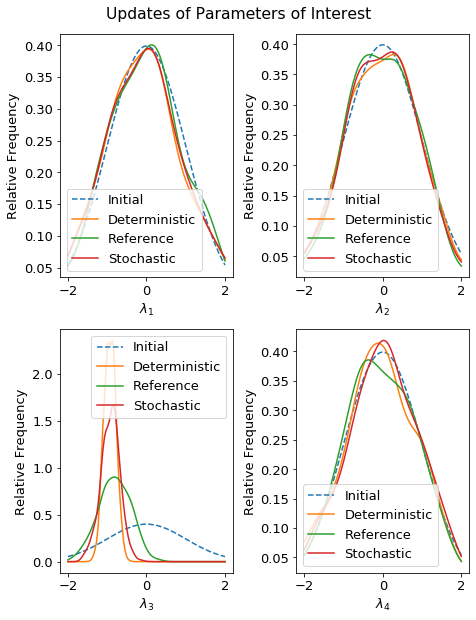

In [83]:
# fontsize
plt.rcParams.update({'font.size': 13})

# input space
x = np.linspace(-2,2,100)

# compare 3 components of input spaces
fig_lam, axes = plt.subplots(2,2,constrained_layout=True)
fig_lam.set_figheight(8.5)
fig_lam.set_figwidth(6.5)

curve_labels = {'cKL4': 'Deterministic',
                'cKL100': 'Reference',
                'cKL4_E': 'Stochastic'}

# input space
for k,ax_row in enumerate(axes):
    for j,ax in enumerate(ax_row):
        fig_lam.sca(ax)
        plt.plot(x,sps.norm.pdf(x,0,1),label='Initial',ls='--')
        
        this_lambda = k+j if k==0 else k+j+1
        
        # plot updated KDE for each KL-component i
        for i,example in enumerate(my_output.keys()):
            this_kde = sps.gaussian_kde(my_input[example]['lam_init'][:,this_lambda],
                                        weights=my_output[example]['weights'])
            plt.plot(x,this_kde(x),label=curve_labels[example],color='C'+str(i+1))
        plt.legend()
        plt.title('')
        plt.xlabel('$\lambda_{}$'.format(this_lambda+1))
        plt.ylabel('Relative Frequency')


#plt.tight_layout()

fig_lam.suptitle('Updates of Parameters of Interest')

In [85]:
# fig_lam.savefig('KL_lam_update.png',bbox_inches='tight')

Plots the Push-forwards

Text(0.5, 1, 'Updated Predictions')

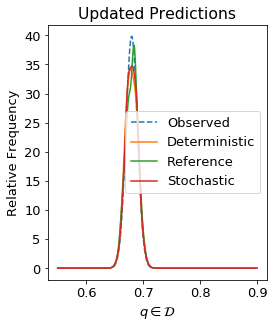

In [108]:
# fontsize
plt.rcParams.update({'font.size': 13})

# input space
x = np.linspace(0.55,0.9,250)

# compare 3 components of input spaces
fig_pf, ax = plt.subplots(1)
fig_pf.set_figheight(4.5)
fig_pf.set_figwidth(4)

curve_labels = {'cKL4': 'Deterministic',
                'cKL100': 'Reference',
                'cKL4_E': 'Stochastic'}


fig_pf.sca(ax)
plt.plot(x,data_pdf.pdf(x),label='Observed',ls='--')

# plot pf-updated KDE for each KL-component i
for i,example in enumerate(my_output.keys()):
    this_kde = sps.gaussian_kde(my_output[example]['pf_samples'],
                                weights=my_output[example]['weights'])
    plt.plot(x,this_kde(x),label=curve_labels[example],color='C'+str(i+1))
plt.legend()
plt.xlabel('$q\\in\\mathcal{D}$')
plt.ylabel('Relative Frequency')
plt.tight_layout()
plt.title('Updated Predictions')

In [111]:
# fig_pf.savefig('KL_data_update.png',bbox_inches='tight')

Both initial and updated predicted

Text(0.5, 1, 'Updated Predictions')

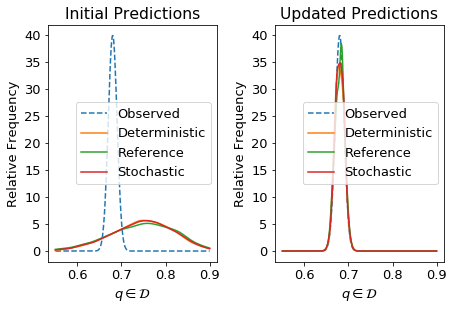

In [112]:
# fontsize
plt.rcParams.update({'font.size': 13})

# input space
x = np.linspace(0.55,0.9,250)

# compare 3 components of input spaces
fig_pfB, ax = plt.subplots(1,2)
fig_pfB.set_figheight(4.5)
fig_pfB.set_figwidth(6.5)

curve_labels = {'cKL4': 'Deterministic',
                'cKL100': 'Reference',
                'cKL4_E': 'Stochastic'}


fig_pfB.sca(ax[0])
plt.plot(x,data_pdf.pdf(x),label='Observed',ls='--')

for i,example in enumerate(my_output.keys()):
    plt.plot(x,my_output[example]['pf_kde'](x),label=curve_labels[example],color='C'+str(i+1))
plt.legend()
plt.title('Initial Predictions')
plt.xlabel('$q\\in\\mathcal{D}$')
plt.ylabel('Relative Frequency')



# data space
fig_pfB.sca(ax[1])
plt.plot(x,data_pdf.pdf(x),label='Observed',ls='--')

# plot pf-updated KDE for each KL-component i
for i,example in enumerate(my_output.keys()):
    this_kde = sps.gaussian_kde(my_output[example]['pf_samples'],
                                weights=my_output[example]['weights'])
    plt.plot(x,this_kde(x),label=curve_labels[example],color='C'+str(i+1))
plt.legend()
plt.xlabel('$q\\in\\mathcal{D}$')
plt.ylabel('Relative Frequency')
plt.tight_layout()
plt.title('Updated Predictions')

In [113]:
# fig_pfB.savefig('KL_data_update_both.png',bbox_inches='tight')

Plots the most typical fields

In [11]:
'This is the value: {:e}'.format(6**50)

'This is the value: 8.082813e+38'

In [103]:
# choose example fields to plot
n_fields = 6

for example in my_output.keys():
    print('This Example ',example, ':')
    nKL = my_input[example]['nKL']
    print(lam_samples[:,0:nKL].shape)
    likely_values = np.prod(lam_init.pdf(lam_samples)[:,0:nKL],axis=1)*my_output[example]['weights']
    likely_index = np.argsort(likely_values)[-n_fields::]
    print(likely_index)
    print('Likely Values: ', likely_values[likely_index])
    print('weights: ', my_output[example]['weights'][likely_index])
    print()
    
    my_output[example]['likely_index'] = likely_index
    

This Example  cKL4 :
(3500, 4)
[2370  290  132 2366 2765 3006]
Likely Values:  [0.17608528 0.17899231 0.18087106 0.18640995 0.18718514 0.19363448]
weights:  [11.87953837 11.19814214 12.66495483 11.10075952 12.26705209 12.74924658]

This Example  cKL100 :
(3500, 100)
[2331 3189 1114 2343  789 2431]
Likely Values:  [1.18154677e-55 1.32816099e-55 1.36570661e-55 2.80307827e-55
 2.06085238e-54 4.02950645e-54]
weights:  [ 7.8119136   3.30210937  0.99802596 13.51972581 12.70705102 10.61513693]

This Example  cKL4_E :
(3500, 4)
[1853 2791   37 2716 3006 2286]
Likely Values:  [0.16574231 0.17357267 0.17765969 0.18116025 0.18750329 0.19490312]
weights:  [12.241871   12.16876653 12.31512966 12.35988502 12.34555759 12.43373084]



The above shows that the most likely sample values are not always the sample with the highest update.

In [104]:
list(my_output[example].keys())

['perm_list',
 'lam_init',
 'sample_u',
 'pf_samples',
 'pf_kde',
 'weights',
 'likely_index']

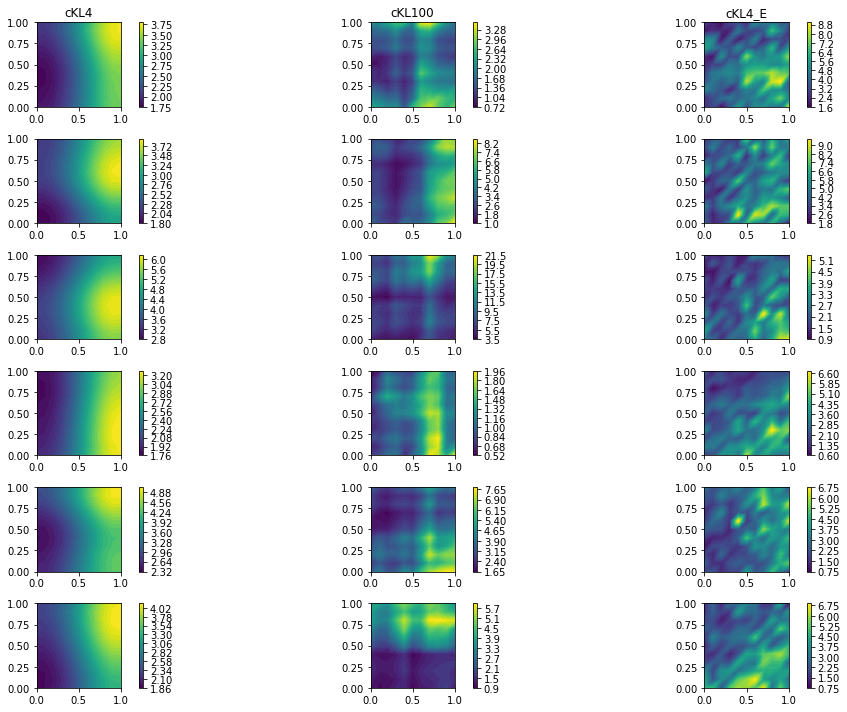

In [105]:
# compare permeability fields
fig_perm, axes = plt.subplots(n_fields,len(my_output.keys()))
fig_perm.set_figheight(10)
fig_perm.set_figwidth(16)

# colorscheme for the plots
these_colors = sns.cubehelix_palette(light=1,dark=0, as_cmap=True)

# plot on each axes
for i in np.arange(n_fields):
    # get color max for the row
    color_maxes = []
#     for j, example in enumerate(my_output.keys()):
#         num = my_output[example]['likely_index'][i]
#         print(type(my_output[example]['perm_list']))
#         color_maxes.append(max(my_output[example]['perm_list'][num].vector()))
#     color_max = max(color_maxes)
    
    # plot each field
    for j, example in enumerate(my_output.keys()):
        num = my_output[example]['likely_index'][i]
        this_output = my_output[example]['perm_list'][num]
        fig_perm.sca(axes[i,j])
        
        field_plot = fn.plot(this_output)#,vmin=0,vmax=color_max)
#         field_plot.set_cmap(these_colors)
#         m = plt.cm.ScalarMappable(cmap=these_colors)
#         m.set_array(this_output.vector())
#         m.set_clim(0,color_max)
        #field_plot.set_clim(0,7)
        plt.colorbar(field_plot,fraction=0.046, pad=0.04)
        
        if i==0:
            axes[i,j].set_title(example)

plt.tight_layout()

All of the means are shifted but 